In [1]:
import pandas as pd

In [2]:
%run data_cleaning.ipynb
%run data_exploration.ipynb

## Data Visualization

In [3]:
import numpy as np
from plotnine import *
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
# import matplotlib as mpl

import matplotlib.dates as mdates
import datetime

%matplotlib inline
warnings.filterwarnings("ignore")

#### a. bar plot

In [4]:
barplot = combined_dataset.groupby(["out_airline_company", "arr_city"]).size().reset_index(name="N")
barplot

,out_airline_company,arr_city,N
0,Lufthansa,GRU,636
1,Lufthansa,JFK,434
2,Swiss,GRU,518
3,Swiss,JFK,854


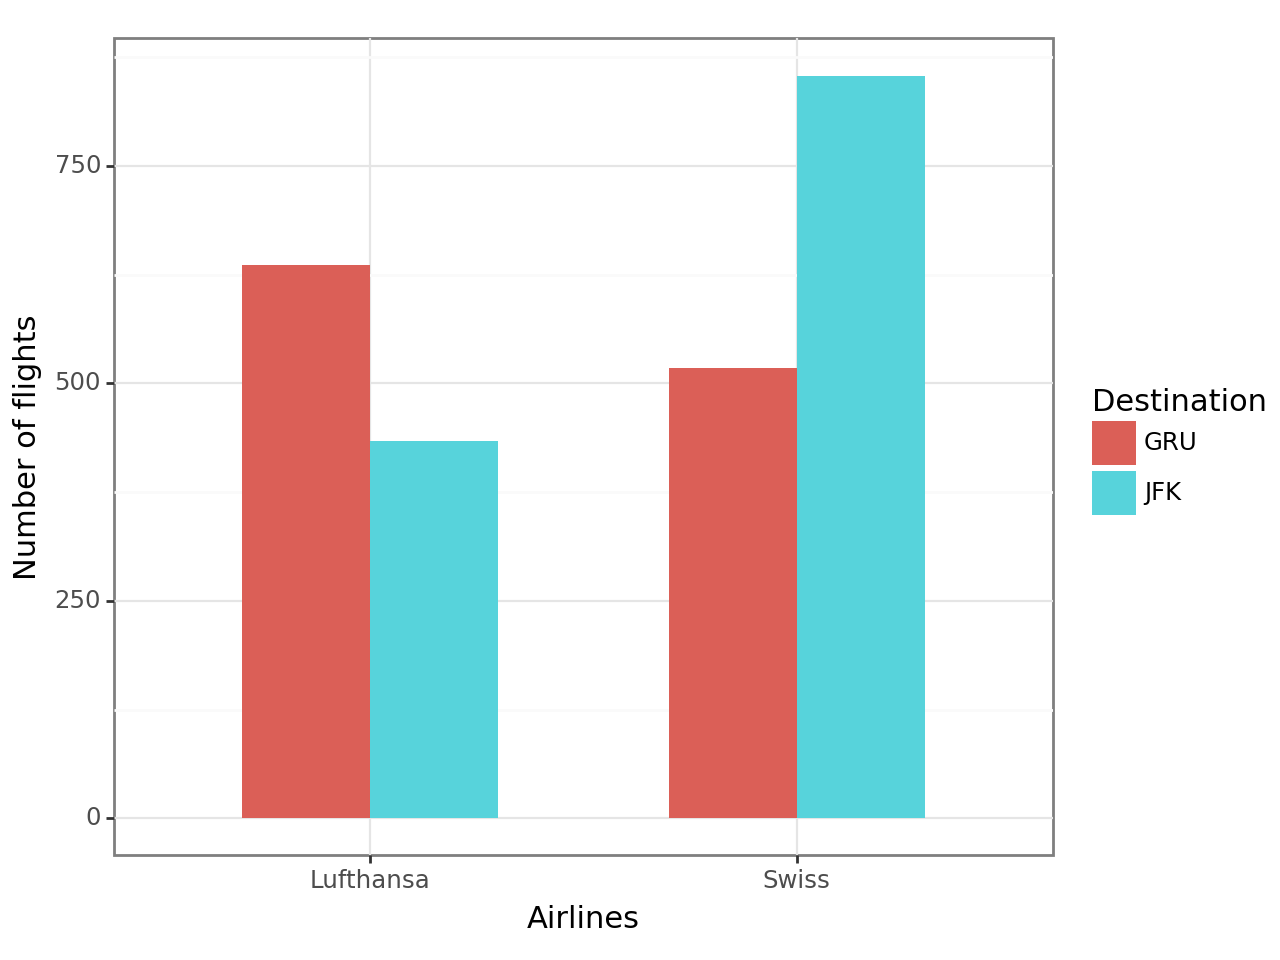

<Figure Size: (640 x 480)>

In [5]:
f1 = (
    ggplot(barplot, aes(x="out_airline_company", y="N", fill="arr_city"))
    + geom_bar(stat="identity", position="dodge", width=0.6, size=0.5)
    + labs(x="Airlines", y="Number of flights", fill="Destination")
    + theme_bw()
    
)
f1

#### b. boxplot

In [20]:
lufthansa_nyc = combined_dataset.loc[(combined_dataset.out_airline_company == 'Lufthansa') & (combined_dataset.arr_city=='JFK')]
swiss_nyc = combined_dataset.loc[(combined_dataset.out_airline_company == 'Swiss') & (combined_dataset.arr_city=='JFK')]
lufthansa_sao = combined_dataset.loc[(combined_dataset.out_airline_company == 'Lufthansa') & (combined_dataset.arr_city=='GRU')]
swiss_sao = combined_dataset.loc[(combined_dataset.out_airline_company == 'Swiss') & (combined_dataset.arr_city=='GRU')]

##### b1. boxplots for New York City

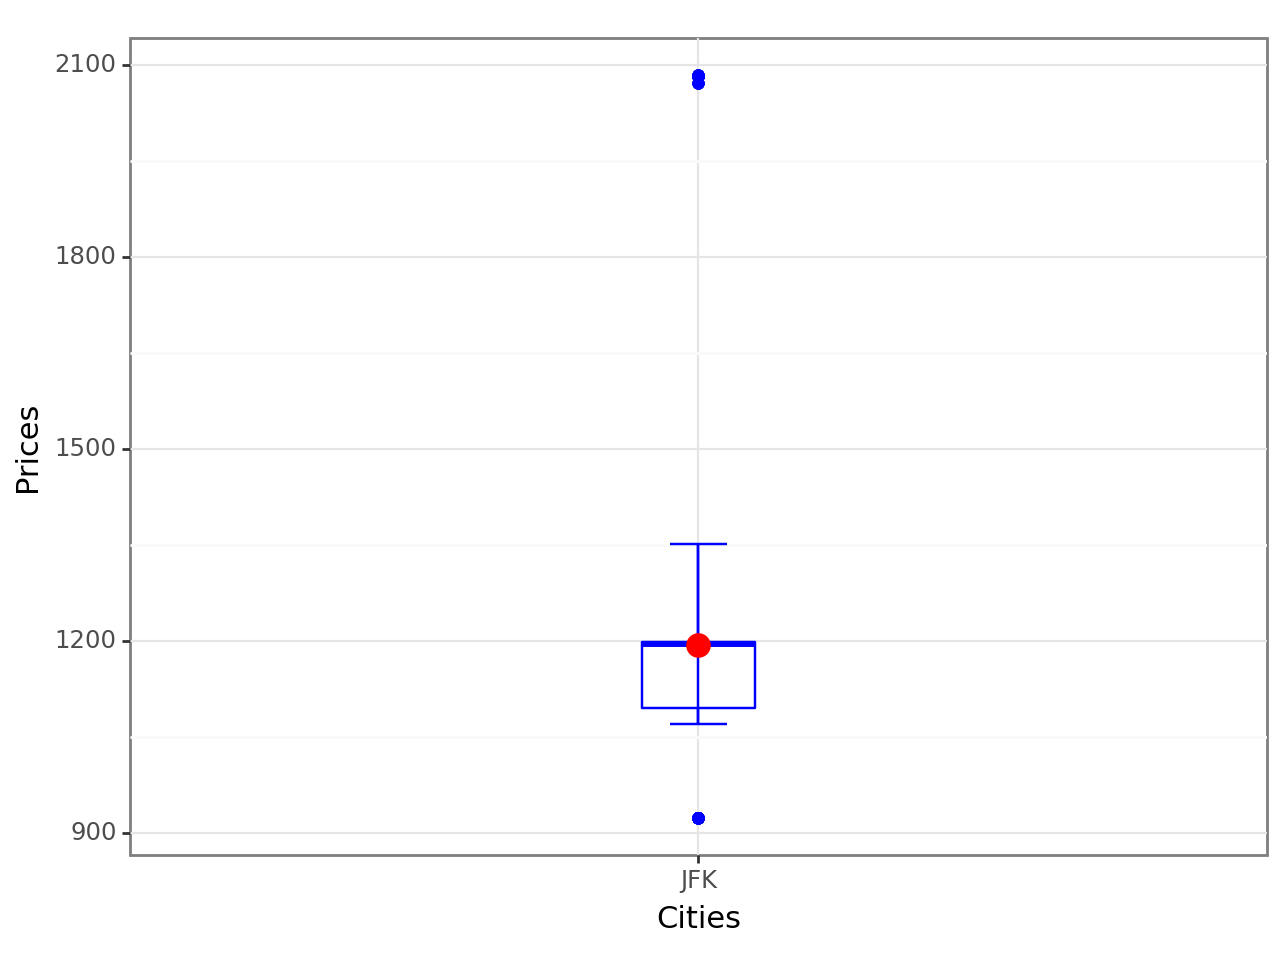

<Figure Size: (640 x 480)>

In [23]:
f2 = (
    ggplot(lufthansa_nyc, aes(y='ticket_price', x='arr_city'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
)
f2

f2 = f2 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
f2

f2 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red")

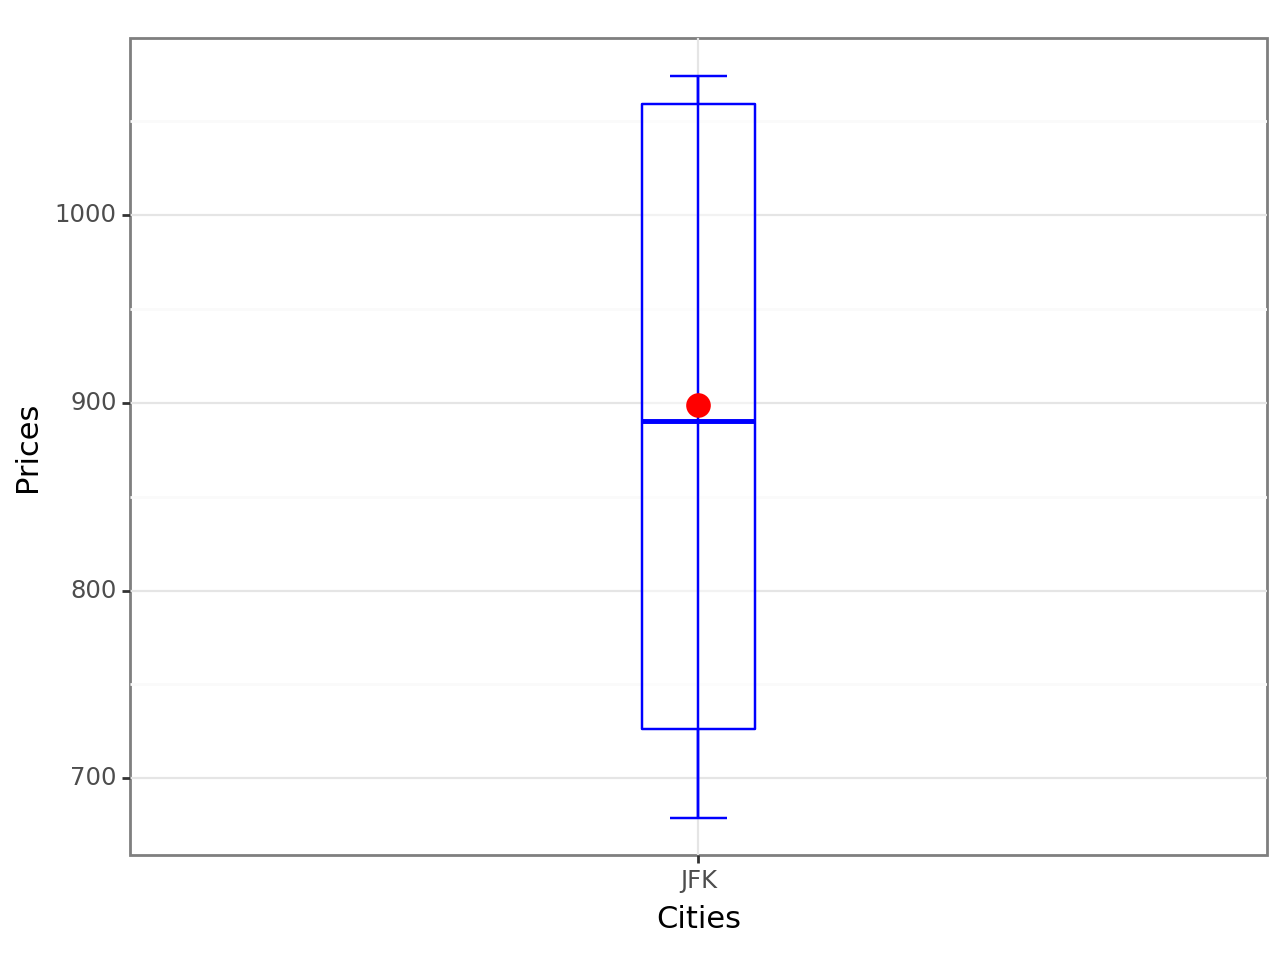

<Figure Size: (640 x 480)>

In [24]:
f3 = (
    ggplot(swiss_nyc, aes(y='ticket_price', x='arr_city'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
)
f3

f3 = f3 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
f3

f3 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red")

##### b2. boxplots for São Paulo destination

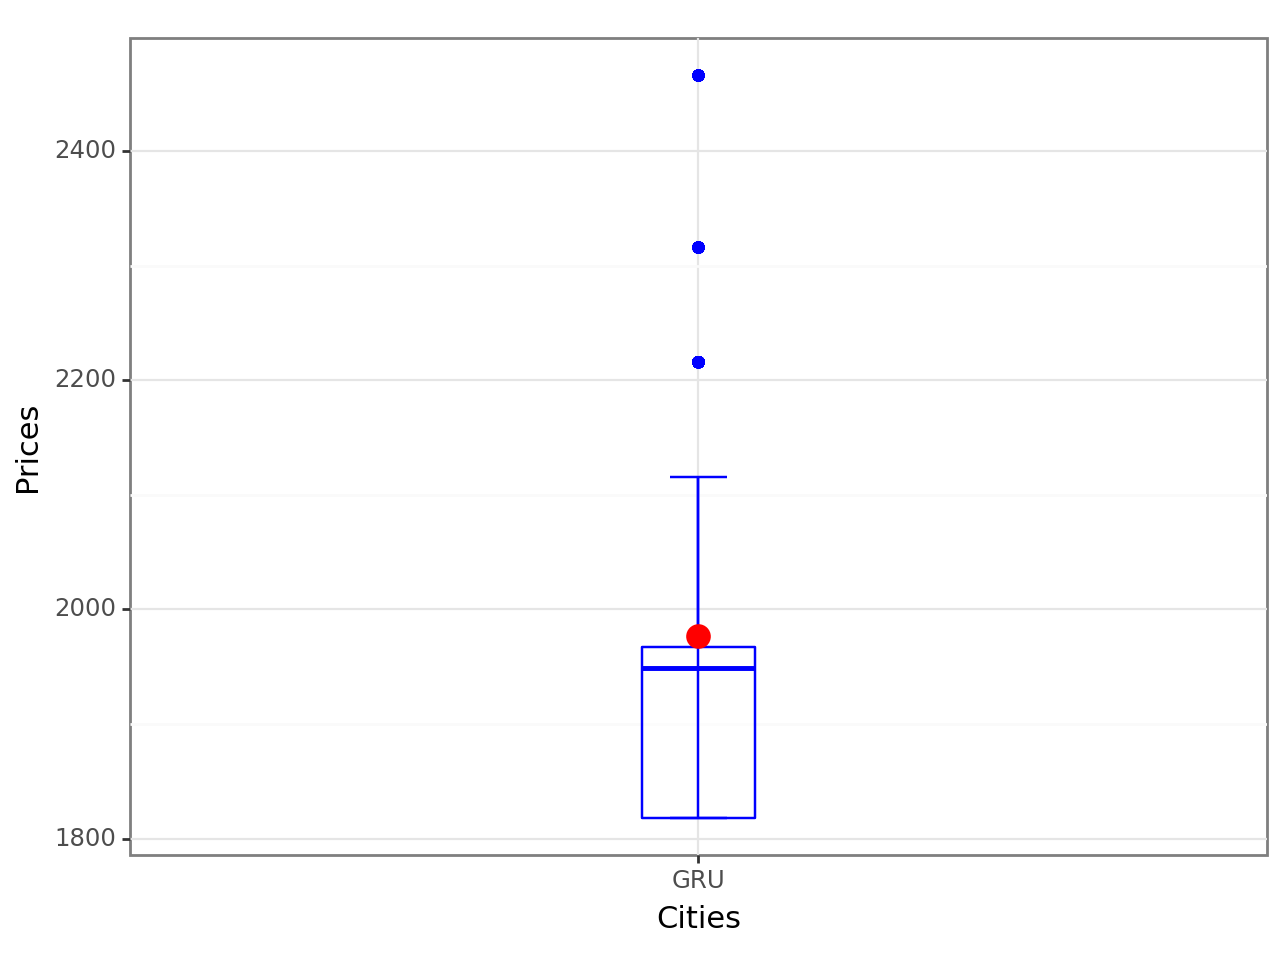

<Figure Size: (640 x 480)>

In [27]:
f4 = (
    ggplot(lufthansa_sao, aes(y='ticket_price', x='arr_city'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
)
f4

f4 = f4 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
f4

f4 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red")

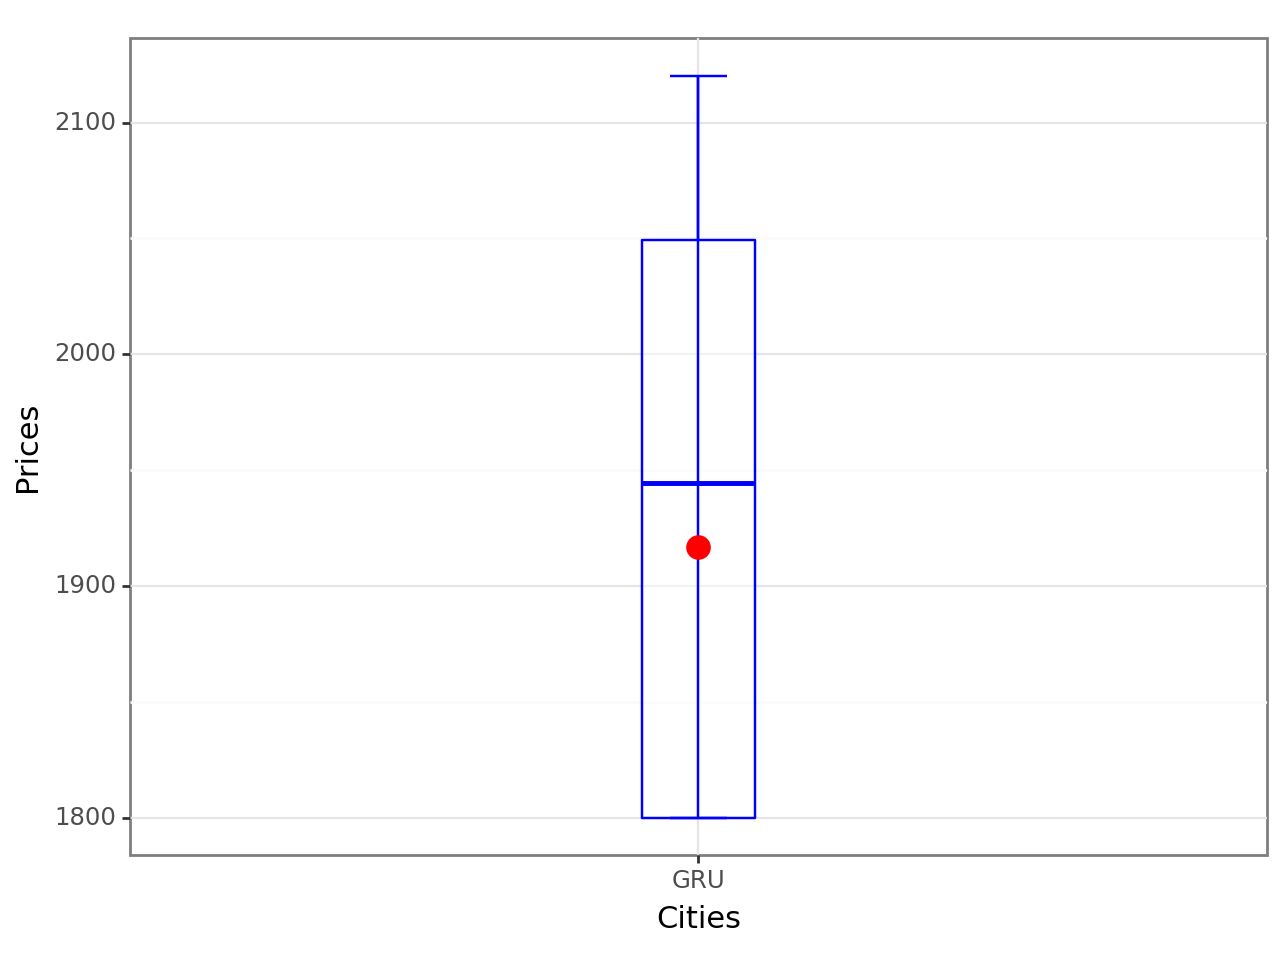

<Figure Size: (640 x 480)>

In [28]:
f5 = (
    ggplot(swiss_sao, aes(y='ticket_price', x='arr_city'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
)
f5

f5 = f5 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
f5

f5 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red")